# Data preparation

In [1]:
import sys 
import time
from geopy.geocoders import Nominatim, GoogleV3, Bing
import folium
from bs4 import BeautifulSoup
import requests
import numpy as np
import googleCreds
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn import preprocessing

#Custom functions
from update import getCompaniesDataframe

### 1. Companies' locations


Specifying job name and region for the search and number of pages to work with.
I use indeed.com for job search as it allows easy web scraping with no restrictons and API's

In [2]:
help(getCompaniesDataframe)

Help on function getCompaniesDataframe in module update:

getCompaniesDataframe(googleAPIKey, jobName='data scientist', locationName='Milano Lombardia', resource='https://it.indeed.com/', maxPages=1, dfPath='dfCompanies.csv', saveCSV=True, dropNAs=True)
    The function returns a dataframe with following features:
    
    - company name (companyName): str
    - job name (jobName): str
    - link to the description of the position (link): str
    - latitude of company's headquarters based on Google Maps Search (lt): float
    - longitude of company's headquarters based on Google Maps Search (lg): float
    - address of company's headquarters based on Google Maps Search (address): str
    
    If getting one of the features was unsuccesful it is replaced by np.nan (numpy NAN).
    
    Inputs:
        googleAPIKey(str):  path to Google Maps API key
        
        jobName     (str):  job name for the search, 
                            default: "data scientist"
    
        locaionNam

In [3]:
dfCompanies = getCompaniesDataframe(jobName="junior data scientist", 
                                    maxPages = 1, 
                                    googleAPIKey = googleCreds.GOOGLE_API_KEY)

PwC was succesfully added with address:
Via Pietro Custodi, 12, 20136 Milano MI, Italy

Conflux was succesfully added with address:
1146 19th St NW #400, Washington, DC 20036, USA

A.B.S. Srl was succesfully added with address:
Via Giuseppe Frua, 9, 20146 Milano MI, Italy

BVA Doxa was succesfully added with address:
Via Bartolomeo Panizza, 7, 20144 Milano MI, Italy

PwC was succesfully added with address:
Via Pietro Custodi, 12, 20136 Milano MI, Italy

Jakala was succesfully added with address:
Corso di Porta Romana, 15, 20122 Milano MI, Italy

Siemens S.p.A. was succesfully added with address:
Via Werner Von Siemens, 1, 20128 Milano MI, Italy

Afiniti was succesfully added with address:
Via Marco Burigozzo, 5, 20122 Milano MI, Italy

Vodafone was succesfully added with address:
Via Lorenteggio, 240, 20147 Milano MI, Italy

Hunters Group was succesfully added with address:
Via Natale Battaglia, 8, 20127 Milano MI, Italy

Human Technopole was succesfully added with address:
Via Cristin

In [4]:
dfCompanies

,companyName,jobName,link,lt,lg,address
1,Siemens S.p.A.,Junior Data Scientist in Energy Applications,https://it.indeed.com/rc/clk?jk=6f4497e2d43b0c...,45.510501,9.238687,"Via Werner Von Siemens, 1, 20128 Milano MI, Italy"
2,PwC,Junior Data & Analytics Consultant PRIVATE [CN...,https://it.indeed.com/rc/clk?jk=39981d7cfa0d7d...,45.450796,9.181933,"Via Pietro Custodi, 12, 20136 Milano MI, Italy"
3,Vodafone,Senior Data Scientist\nnuova offerta,https://it.indeed.com/rc/clk?jk=08eebc1528d3cd...,45.447033,9.123240,"Via Lorenteggio, 240, 20147 Milano MI, Italy"
4,Human Technopole,Computational Biologist / Staff Scientist\nnuo...,https://it.indeed.com/rc/clk?jk=cf5ea0495762e5...,45.522247,9.099587,"Via Cristina Belgioioso, 171, 20157 Milano MI,..."
5,Adecco,JR DIGITAL MARKETING DATA SCIENTIST FOR YOOX N...,https://it.indeed.com/rc/clk?jk=ea17ff981e824a...,45.480738,9.182914,"Viale Francesco Crispi, 17, 20121 Milano MI, I..."
7,Jakala,Junior Data Scientist,https://it.indeed.com/rc/clk?jk=b374228c517fa0...,45.459619,9.191154,"Corso di Porta Romana, 15, 20122 Milano MI, Italy"
8,Sprim Italia Srl,JR DATA SCIENTIST,https://it.indeed.com/rc/clk?jk=8d6a6d4ca115ed...,45.464381,9.180261,"Via Brisa, 3, 20123 Milano MI, Italy"
9,GERI HDP SRL,Ricerca 1 JUNIOR DATA SCIENTIST,https://it.indeed.com/rc/clk?jk=41156479908e95...,45.435589,9.151115,"Via Lago di Nemi, 25, 20142 Milano MI, Italy"


After I get the address based on search results I use it to get location (latitude and longitude) for each company.

Now I create a list of location objects using geolocator and trying to restrict location only by Milan area because some companies' HQs are located somewhere else in the world.

Not all of the companies were found succesfully, but it's fine. Now I create a dictionary for a subsequent dataframe containing info on companies location. In the same cycle I add markers into a feature group for the future folium map.

In [5]:
dfCompanies.to_pickle('dfCompanies.pkl')

### 2. Mean and median locations

Here I calculate the mean and median location of the companies' location points which should be optimal for living.

In [6]:
meanLat = dfCompanies["lt"].mean()
meanLon = dfCompanies["lg"].mean()

medianLat = dfCompanies["lt"].median()
medianLon = dfCompanies["lg"].median()

medianLocation = (medianLat, medianLon)
meanLocation = (meanLat, meanLon)

In [7]:
print("Mean Location (lat, lon):", "\t" , meanLat, "\t" ,meanLon)
print("Median Location (lat, lon):", "\t" , medianLat, "\t\t" , medianLon)

Mean Location (lat, lon): 	 45.4713628875 	 9.168611425
Median Location (lat, lon): 	 45.461999649999996 		 9.181097150000001


### 4. Green Zones
The next step is to analyze how green each zone of Milan is. I used data on green zones in order to obtain Vegetation Concentration (area of green zones relative to total area).

In [10]:
#Source: https://dati.comune.milano.it/dataset/ds339-territorioambiente-aree-verdi-zona-superficie-2014
#Last Access Date: 11/08/2020
greenZonesPath = 'https://dati.comune.milano.it/dataset/da6bc86d-c27f-4256-84eb-86c35dad7d0e/resource/bd55cd57-4dd7-4d72-b182-de4f4b7de8c6/download/ds339_territorioambiente_aree-verdi-zona-superficie_2014.csv'
dfGreenRaw = pd.read_csv(greenZonesPath,
                     header = 0, sep = ";", encoding='latin-1')

In [11]:
dfGreenRaw.head()

,Zona,Area,ID Località,Nome località,Descrizione,Tipo,Classificazione,Classificazione ISTAT,AFFIDATARIO,Superficie totale in mq
0,1,1,1,piazza Castello - Minghetti,aiuola spartitraffico,Filare,Verde di arredo stradale,4 - Aree di arredo urbano,Appaltatore Servizio Manutenzione,"573,07"
1,1,2,2,piazza Paolo VI,area verde,Parco,Giardino,1 - Verde attrezzato,Appaltatore Servizio Manutenzione,"1313,85"
2,1,3,3,via San Simpliciano,filare alberato - parcheggio,Filare,Filare alberato,4 - Aree di arredo urbano,Appaltatore Servizio Manutenzione,"2,82"
3,1,4,4,via De Marchi Marco,filare alberato,Filare,Filare alberato,4 - Aree di arredo urbano,Appaltatore Servizio Manutenzione,"212,28"
4,1,5,5,via Croce Rossa,filare alberato,Filare,Filare alberato,4 - Aree di arredo urbano,Appaltatore Servizio Manutenzione,"6,47"


In [12]:
dfGreenRaw.dtypes

Zona                        int64
Area                        int64
ID Località                 int64
Nome località              object
Descrizione                object
Tipo                       object
Classificazione            object
Classificazione ISTAT      object
AFFIDATARIO                object
Superficie totale in mq    object
dtype: object

In [13]:
dfGreenRaw["Superficie totale in mq"] = dfGreenRaw["Superficie totale in mq"].apply(lambda x: float(str(x).replace(",",".")))

In [14]:
dfGreenRaw.dtypes

Zona                         int64
Area                         int64
ID Località                  int64
Nome località               object
Descrizione                 object
Tipo                        object
Classificazione             object
Classificazione ISTAT       object
AFFIDATARIO                 object
Superficie totale in mq    float64
dtype: object

Calculating green zone area for each zone

In [16]:
dfGreenRaw = dfGreenRaw.groupby(by="Zona").sum()
dfGreenRaw = dfGreenRaw.reset_index()
dfGreenRaw.to_pickle('dfGreenRaw.pkl')
dfGreenRaw

,Zona,Area,ID Località,Superficie totale in mq
0,1,55548,116980,1108469.89
1,2,30772,177776,1067197.61
2,3,28190,196456,1732049.53
3,4,44075,350099,2133898.99
4,5,37416,366773,1745979.00
5,6,42285,458818,2125661.51
6,7,74550,671771,5294580.71
7,8,118343,1033605,3549902.76
8,9,116444,1193436,3677692.48


Getting info on total area of each zone from Wikipedia

In [18]:
dfZones = pd.read_html('https://en.wikipedia.org/wiki/Municipalities_of_Milan',
                          flavor='bs4')
dfZones = dfZones[1][:9]
dfZones.to_pickle('dfZones.pkl')
dfZones

,Borough,Name,Area(km2),Population(2014),Population density(inhabitants/km2),Quartieri (districts)
0,1.0,Centro storico,9.67,96315.000,11074,"Brera, Centro Storico, Conca del Naviglio, Gua..."
1,2.0,"Stazione Centrale, Gorla, Turro, Greco, Cresce...",12.58,153.109,13031,"Adriano, Crescenzago, Gorla, Greco, Loreto, Ma..."
2,3.0,"Città Studi, Lambrate, Porta Venezia",14.23,141229.000,10785,"Casoretto, Cimiano, Città Studi, Dosso, Lambra..."
3,4.0,"Porta Vittoria, Forlanini",20.95,156.369,8069,"Acquabella, Calvairate, Castagnedo, Cavriano, ..."
4,5.0,"Vigentino, Chiaravalle, Gratosoglio",29.87,123779.000,4487,"Basmetto, Cantalupa, Case Nuove, Chiaravalle, ..."
5,6.0,"Barona, Lorenteggio",18.28,149000.000,8998,"Arzaga, Barona, Boffalora, Cascina Bianca, Con..."
6,7.0,"Baggio, De Angeli, San Siro",31.34,170814.000,6093,"Assiano, Baggio, Figino, Fopponino, Forze Arma..."
7,8.0,"Fiera, Gallaratese, Quarto Oggiaro",23.72,181669.000,8326,"Boldinasco, Bullona, Cagnola, Campo dei Fiori,..."
8,9.0,"Porta Garibaldi, Niguarda",21.12,181598.000,9204,"Affori, Bicocca, Bovisa, Bovisasca, Bruzzano, ..."


Merging two Data frames and calculating the new column

In [19]:
dfGreen = pd.concat([dfGreenRaw, dfZones],axis = 1)[["Zona","Superficie totale in mq","Area(km2)"]]
#Had to rename column because geojson file had ZONADEC variable for zone number. 
#I'll need that when creating a map.
dfGreen.columns = ["ZONADEC","GreenArea", "TotalArea"]


In [20]:
#Converting m2 to km2
dfGreen["GreenArea"] = dfGreen["GreenArea"]/1000000
dfGreen

,ZONADEC,GreenArea,TotalArea
0,1,1.108470,9.67
1,2,1.067198,12.58
2,3,1.732050,14.23
3,4,2.133899,20.95
4,5,1.745979,29.87
5,6,2.125662,18.28
6,7,5.294581,31.34
7,8,3.549903,23.72
8,9,3.677692,21.12


In [21]:
dfGreen["GreenConc"] = dfGreen["GreenArea"]/dfGreen["TotalArea"]
dfGreen

,ZONADEC,GreenArea,TotalArea,GreenConc
0,1,1.108470,9.67,0.114630
1,2,1.067198,12.58,0.084833
2,3,1.732050,14.23,0.121718
3,4,2.133899,20.95,0.101857
4,5,1.745979,29.87,0.058453
5,6,2.125662,18.28,0.116283
6,7,5.294581,31.34,0.168940
7,8,3.549903,23.72,0.149659
8,9,3.677692,21.12,0.174133


In [22]:
dfGreen.to_pickle("dfGreen.pkl")

### 5. Air Quality
In this section I analyze data on contamination for 2019 and 2020 obtained from stations located in Milano.
I will calculate an Eco score which is an inverted value of mean normalized concentrations of contaminants.

In [38]:
air2020path = 'https://dati.comune.milano.it/dataset/ccf8b61d-728f-46e7-bee9-e685c7b6cd35/resource/88c1e729-420e-433f-9397-875b54aa471d/download/qaria_datoariagiornostazione_2021-01-01.csv'

dfAirRaw2020 = pd.read_csv(air2020path, sep=';')
dfAirRaw2020.dropna(inplace = True)
dfAirRaw2020['data']=pd.to_datetime(dfAirRaw2020['data'], format='%Y-%m-%d')
dfAirRaw2020.head(10)

,stazione_id,data,inquinante,valore
3,7,2020-12-31,O3,7.0
4,7,2020-12-31,NO2,74.0
5,7,2020-12-31,PM10,43.0
6,6,2020-12-31,C6H6,3.0
7,6,2020-12-31,CO_8h,1.5
8,6,2020-12-31,NO2,72.0
9,6,2020-12-31,PM25,47.0
10,6,2020-12-31,PM10,54.0
14,4,2020-12-31,CO_8h,1.4
16,4,2020-12-31,PM10,48.0


In [39]:
dfAirRaw2020.dtypes

stazione_id             int64
data           datetime64[ns]
inquinante             object
valore                float64
dtype: object

Checking contaminants (inquinante) types ... 

In [40]:
dfAirRaw2020["inquinante"].unique()

array(['O3', 'NO2', 'PM10', 'C6H6', 'CO_8h', 'PM25', 'SO2'], dtype=object)

... and ids of active stations 

In [41]:
dfAirRaw2020["stazione_id"].unique()

array([7, 6, 4, 3, 2])

Here I scale data within each contaminant type

In [42]:
#df['norm_w'] = df['weight'] / df.groupby('word')['weight'].transform('sum')
dfAirRaw2020["normv"] = dfAirRaw2020['valore'] / dfAirRaw2020.groupby('inquinante')['valore'].transform('max')
dfAirRaw2020.sample(10)

,stazione_id,data,inquinante,valore,normv
4127,2,2020-05-07,C6H6,0.5,0.066667
5130,4,2020-03-13,C6H6,1.3,0.173333
753,2,2020-11-18,PM10,51.0,0.283333
5983,2,2020-01-30,PM25,19.0,0.125000
1062,2,2020-11-02,PM25,19.0,0.125000
6159,4,2020-01-22,PM10,51.0,0.283333
5439,2,2020-02-28,PM25,7.0,0.046053
6142,7,2020-01-22,NO2,129.0,0.602804
406,6,2020-12-09,PM10,14.0,0.077778
4123,4,2020-05-07,NO2,61.0,0.285047


In [43]:
dfAirRaw["data"] = pd.to_datetime(dfAirRaw["data"])
dfAirRaw = dfAirRaw.sort_values(by="data")
dfAirRaw

,stazione_id,data,inquinante,valore,normv
6521,2,2020-01-01,SO2,5.0,0.128205
6513,2,2020-01-02,NO2,71.0,0.331776
6510,2,2020-01-02,SO2,7.0,0.179487
6511,2,2020-01-02,PM10,154.0,0.855556
6512,2,2020-01-02,PM25,129.0,0.848684
...,...,...,...,...,...
8,6,2020-12-31,NO2,72.0,0.336449
9,6,2020-12-31,PM25,47.0,0.309211
16,4,2020-12-31,PM10,48.0,0.266667
14,4,2020-12-31,CO_8h,1.4,0.437500


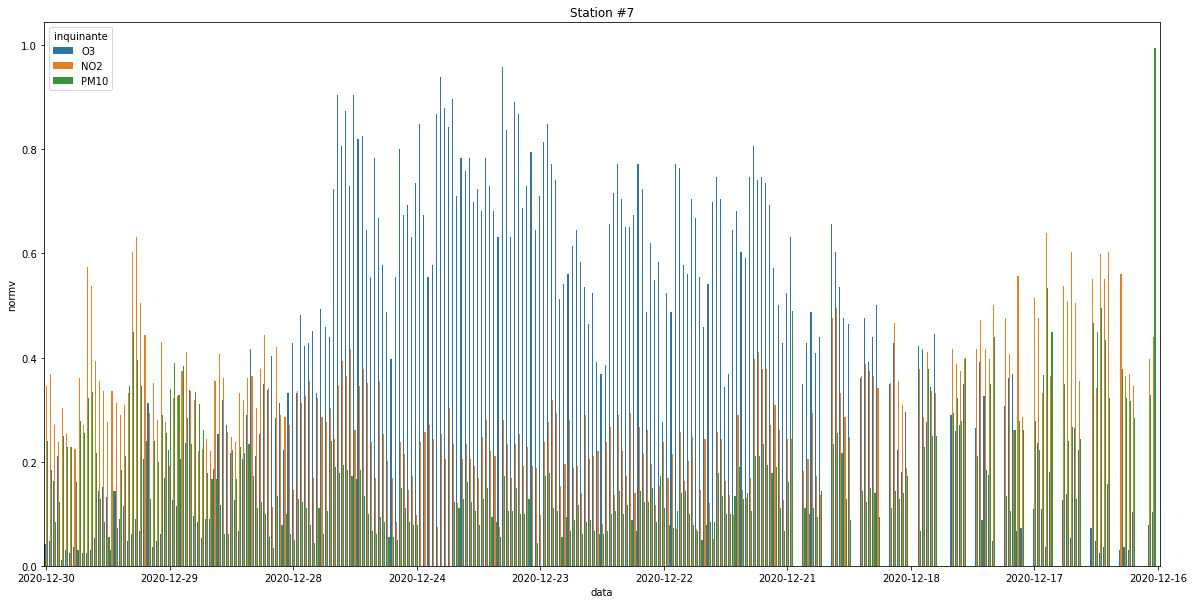

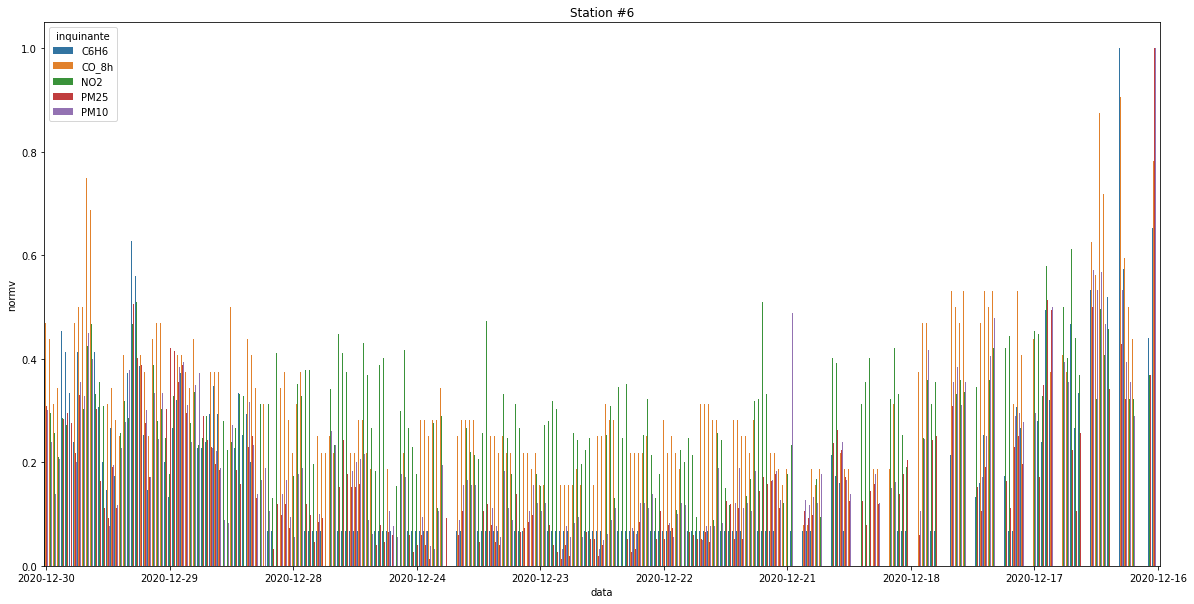

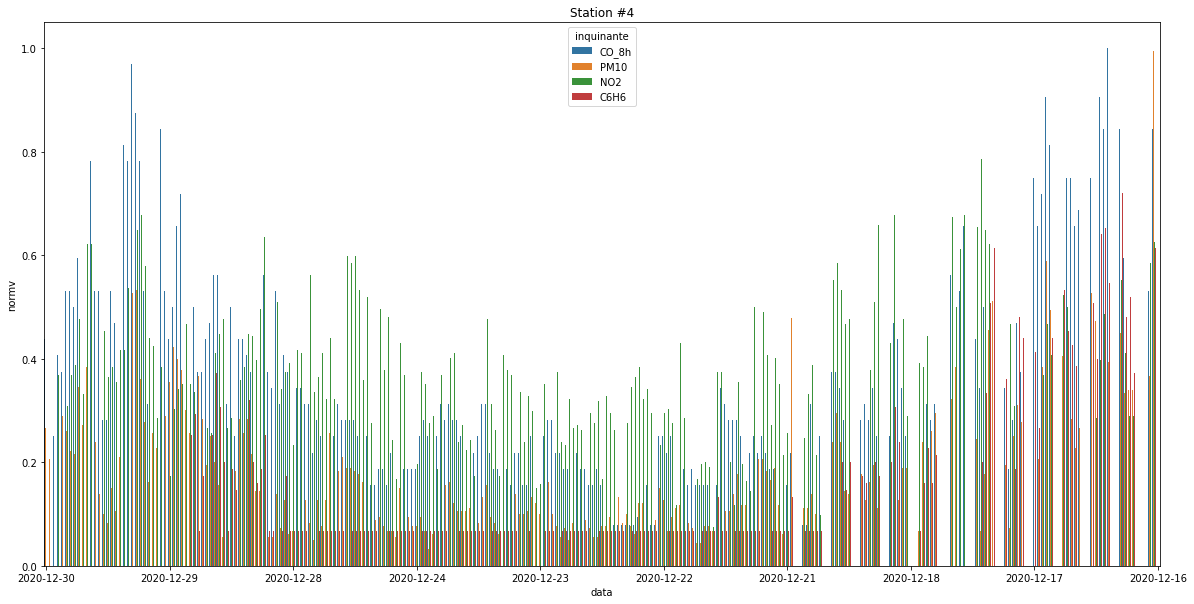

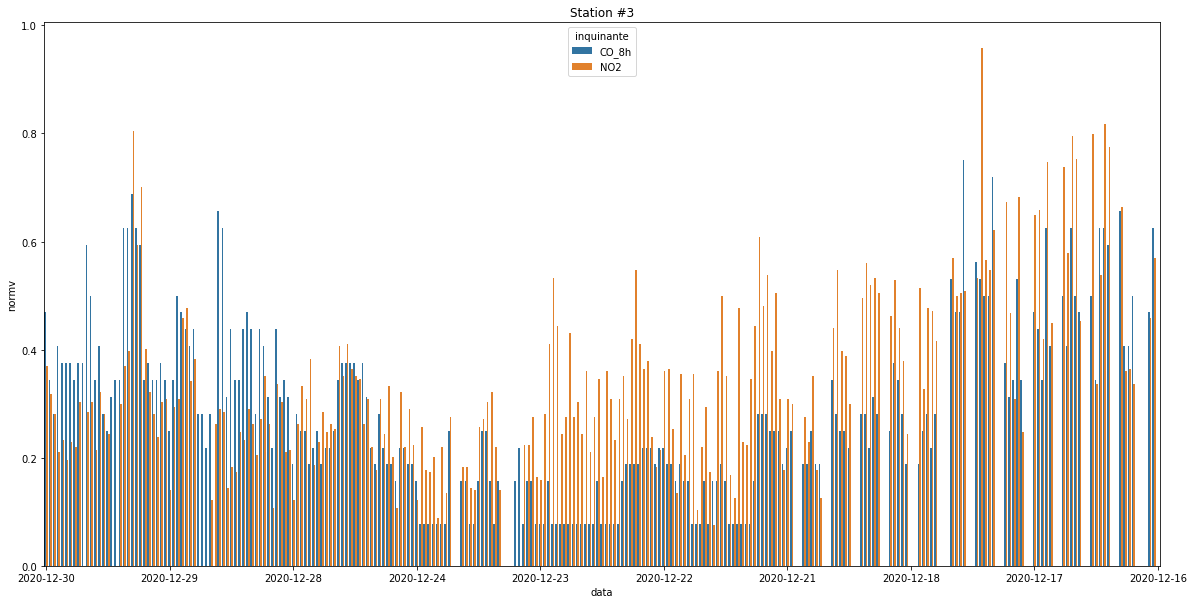

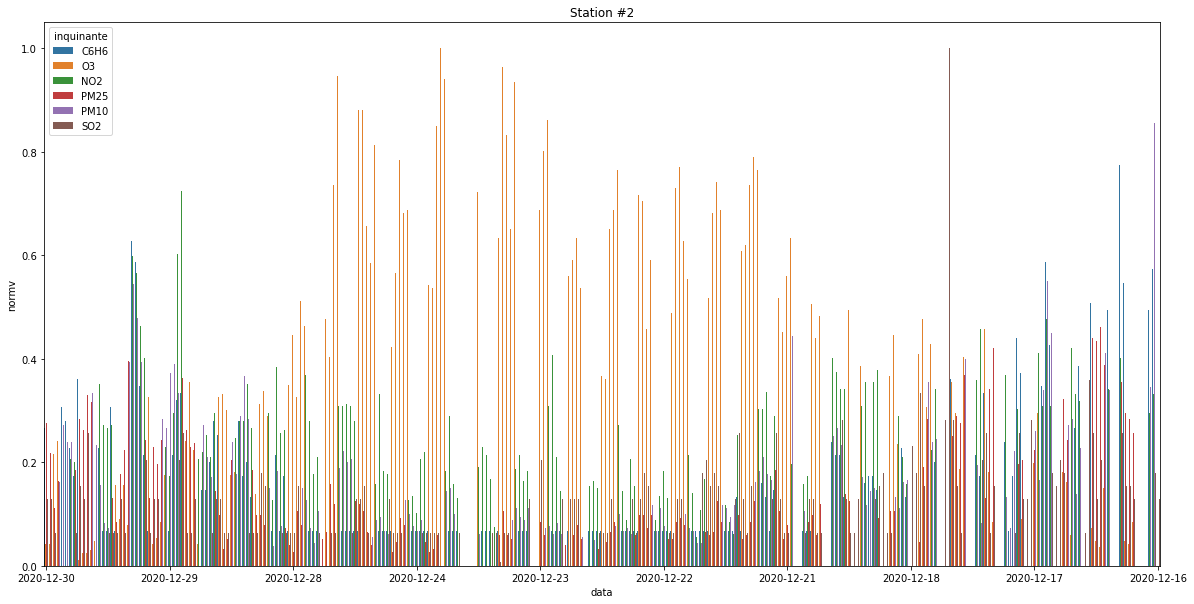

In [44]:
for station in dfAirRaw2020["stazione_id"].unique():
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.barplot(x = dfAirRaw2020["data"].dt.strftime('%Y-%m-%d'), y = "normv", 
                     data = dfAirRaw2020[dfAirRaw2020["stazione_id"] == station], 
                     hue = "inquinante")
    plt.title(f"Station #{station}")
    ax.xaxis.set_major_locator(ticker.MaxNLocator())

In [31]:
#Let's check the data on air quality for 2019 
#Source: https://dati.comune.milano.it/dataset/3e752fec-06fd-421b-ae9b-4d5d7a177640/resource/698a58e6-f276-44e1-92b1-3d2b81a4ad47/download/qaria_datoariagiornostazione_2020-01-08.csv

dfAir2019 = pd.read_csv('https://dati.comune.milano.it/dataset/3e752fec-06fd-421b-ae9b-4d5d7a177640/resource/698a58e6-f276-44e1-92b1-3d2b81a4ad47/download/qaria_datoariagiornostazione_2020-01-08.csv',
                          sep=',')

dfAir2019.dropna(inplace = True)

dfAir2019["data"] = pd.to_datetime(dfAir2019["data"])
dfAir2019 = dfAir2019.sort_values(by="data")
dfAir2019


dfAir2019.sample(10)

,stazione_id,data,inquinante,valore
2189,4,2019-05-13,CO_8h,0.5
2914,3,2019-06-20,CO_8h,0.7
6011,4,2019-12-19,CO_8h,1.6
411,7,2019-01-28,NO2,58.0
3488,4,2019-07-24,NO2,106.0
4820,2,2019-10-14,PM10,54.0
940,4,2019-03-01,NO2,141.0
57,4,2019-01-07,CO_8h,2.2
4675,7,2019-10-04,NO2,60.0
2995,4,2019-06-25,CO_8h,0.9


In [32]:
print(dfAir2019["stazione_id"].unique())
dfAir2019["normv"] = dfAir2019['valore'] / dfAir2019.groupby('inquinante')['valore'].transform('max')
dfAir2019["data"] = pd.to_datetime(dfAir2019["data"])
dfAir2019 = dfAir2019.sort_values(by="data")
dfAir2019

[3 7 6 2 4]


,stazione_id,data,inquinante,valore,normv
0,3,2019-01-03,NO2,51.0,0.217949
5,4,2019-01-03,C6H6,1.5,0.241935
9,2,2019-01-03,PM10,20.0,0.162602
8,2,2019-01-03,SO2,2.5,0.067568
1,3,2019-01-03,CO_8h,1.2,0.324324
...,...,...,...,...,...
6154,6,2019-12-31,CO_8h,1.2,0.324324
6155,6,2019-12-31,C6H6,1.5,0.241935
6147,2,2019-12-31,PM25,42.0,0.500000
6142,4,2019-12-31,C6H6,1.6,0.258065


In [33]:
dfAir2019[dfAir2019["stazione_id"] == 7]

,stazione_id,data,inquinante,valore,normv
21,7,2019-01-03,NO2,54.0,0.230769
20,7,2019-01-03,PM10,32.0,0.260163
22,7,2019-01-03,O3,59.0,0.263393
48,7,2019-01-04,O3,55.0,0.245536
47,7,2019-01-04,NO2,82.0,0.350427
...,...,...,...,...,...
6106,7,2019-12-24,O3,44.0,0.196429
6132,7,2019-12-30,O3,14.0,0.062500
6131,7,2019-12-30,NO2,84.0,0.358974
6157,7,2019-12-31,NO2,56.0,0.239316


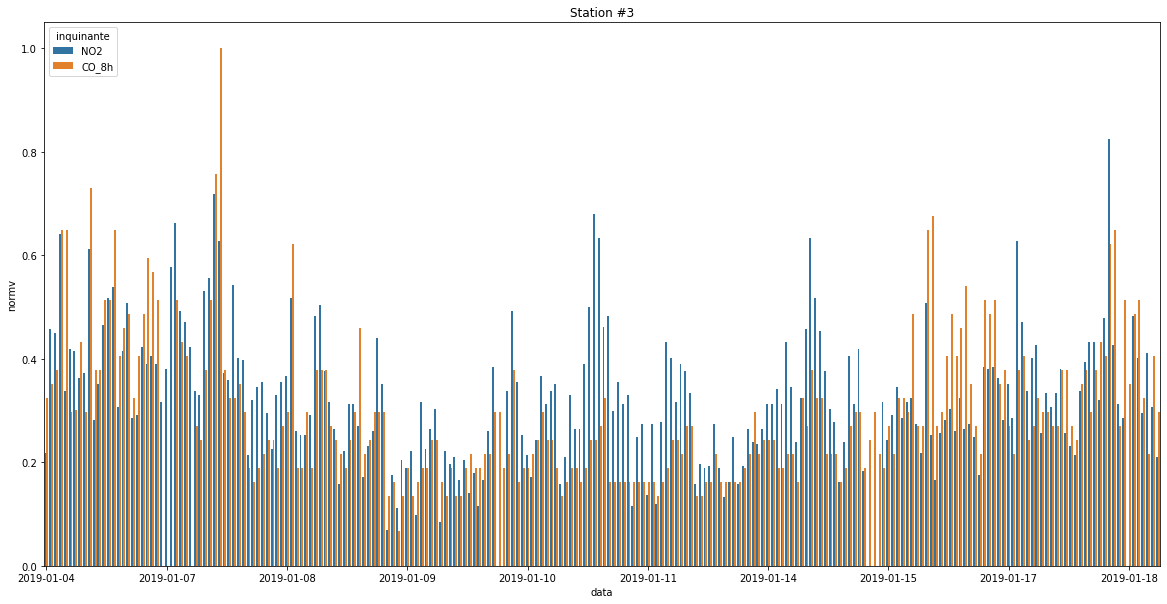

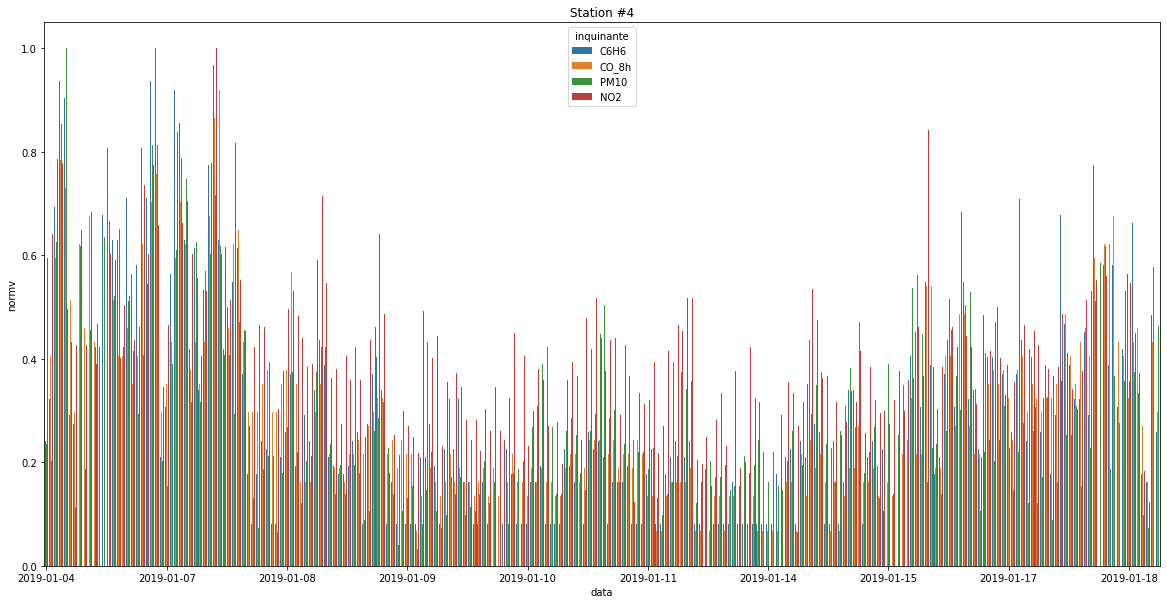

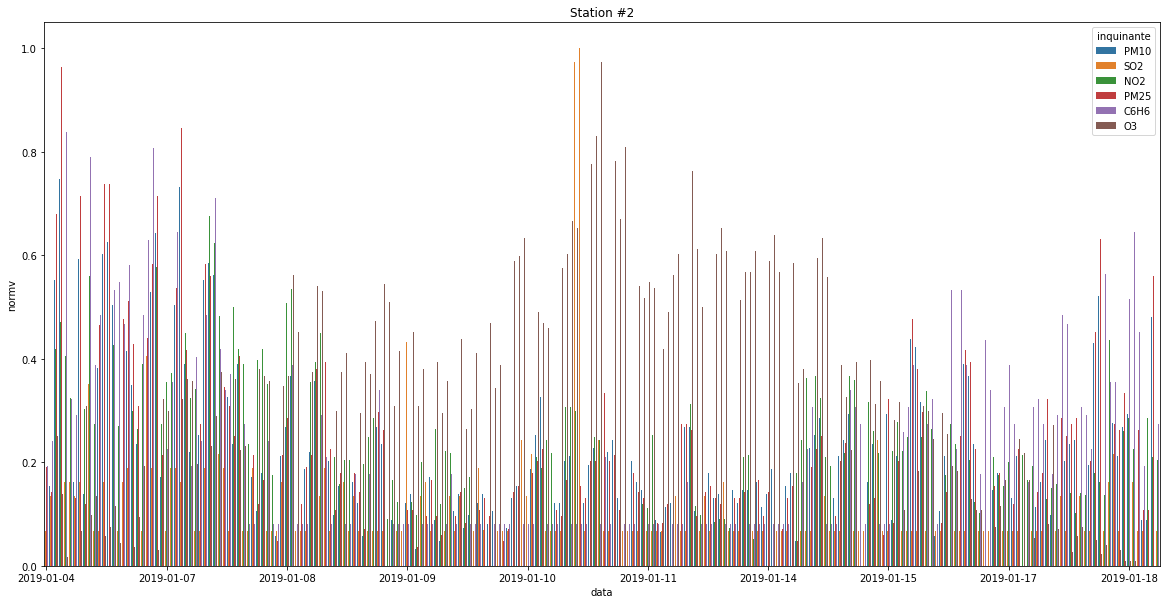

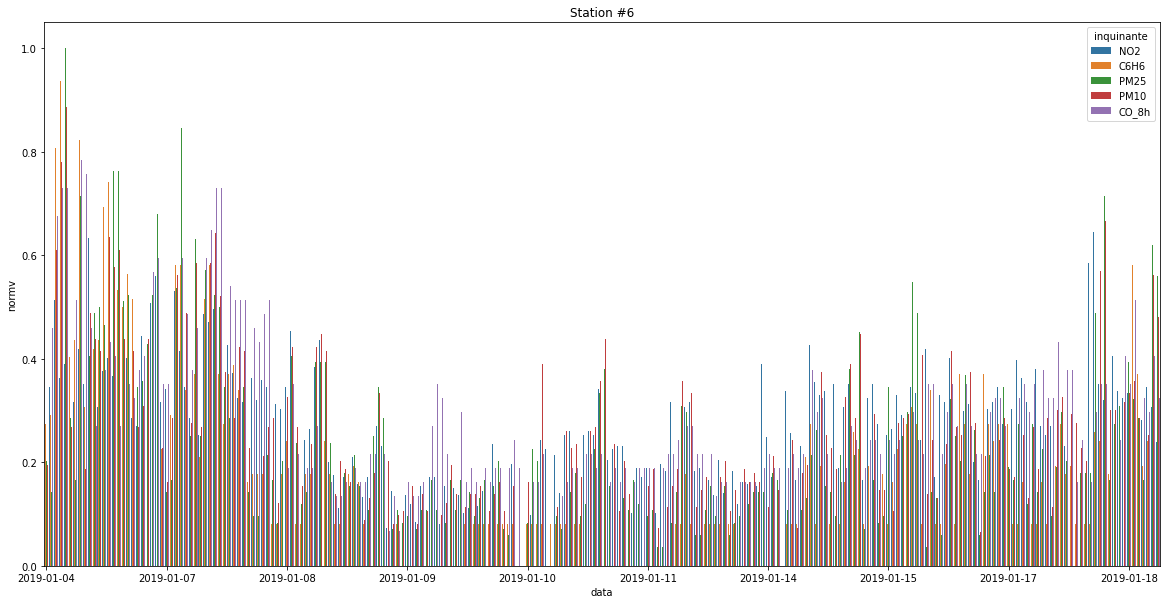

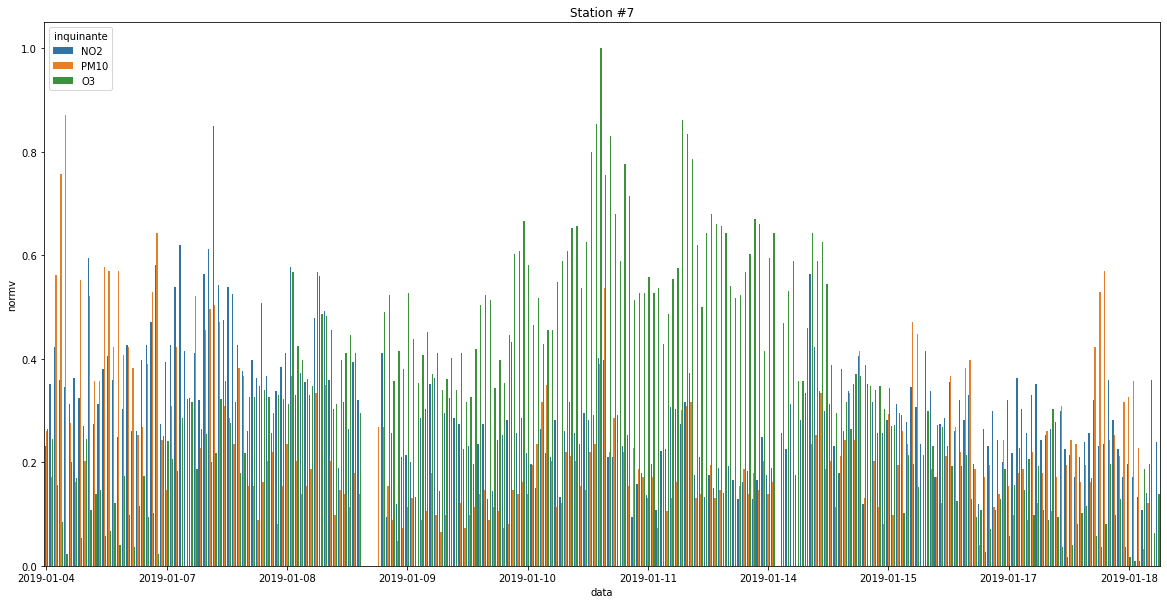

In [34]:
for station in dfAir2019["stazione_id"].unique():
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.barplot(x = dfAir2019["data"].dt.strftime('%Y-%m-%d'), y = "normv", 
                     data = dfAir2019[dfAir2019["stazione_id"] == station], 
                     hue = "inquinante")
    plt.title(f"Station #{station}")
    ax.xaxis.set_major_locator(ticker.MaxNLocator())

We can see that the picture is almost the same for last year and this year. So there's a clear evidence of  seasonality. But analyzing this time series data is out of scope as it would not contribute much to the final goal. But let's check if median values are significantly different

Below I calculate the median value of scaled contamination by all available parameters (contaminants). Even though each station has different set of contaminant data, median value can provide a basis for comparative assesment of contamination.

In [45]:
dfAirScaledMedian2020 = dfAirRaw2020.groupby(by="stazione_id").median()


In [46]:
dfAirScaledMedian2020 = dfAirScaledMedian2020.reset_index()
dfAirScaledMedian2020.columns = ["id_amat", "valore", "normv"]

In [47]:
dfAirScaledMedian2020

,id_amat,valore,normv
0,2,12.0,0.153846
1,3,2.1,0.281250
2,4,11.0,0.250000
3,6,15.0,0.218750
4,7,51.0,0.255556


Let's check if median values are significantly different for stations 3 and 7 as they are pretty close. For that purpose I will use Kruskal-Wallis test (similar to ANOVA but for medians). 

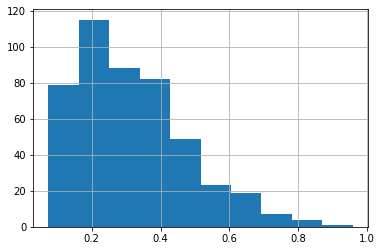

In [48]:
dfAirRaw2020[dfAirRaw2020["stazione_id"]==3]["normv"].hist()

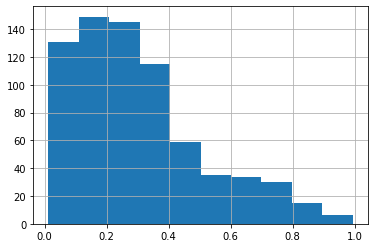

In [49]:
dfAirRaw2020[dfAirRaw2020["stazione_id"]==7]["normv"].hist()

In [50]:
from scipy import stats

stats.kruskal(dfAirRaw2020[dfAirRaw2020["stazione_id"]==7]["normv"].values, dfAirRaw2020[dfAirRaw2020["stazione_id"]==3]["normv"].values)

KruskalResult(statistic=8.50159472343255, pvalue=0.00354835351456659)

p-value is less than 0.05, so these 2 stations have significantly different medians. Let's do the same pairwise test for all of the stations.

In [51]:
testRes = np.zeros((8,8))
for i in dfAirRaw2020["stazione_id"].unique():

    for j in dfAirRaw2020["stazione_id"].unique():
        if i!=j:
            A = dfAirRaw2020[dfAirRaw2020["stazione_id"]==i]["normv"].values
            B = dfAirRaw2020[dfAirRaw2020["stazione_id"]==j]["normv"].values
            res = stats.kruskal(A, B).pvalue
            print(f"for {i}|{j} pvalue = {res}. Significant difference = {res<=0.05}")
            testRes[i, j] = res
            

for 7|6 pvalue = 2.0979197176320886e-10. Significant difference = True
for 7|4 pvalue = 0.017501859004289227. Significant difference = True
for 7|3 pvalue = 0.00354835351456659. Significant difference = True
for 7|2 pvalue = 3.0353939544152114e-31. Significant difference = True
for 6|7 pvalue = 2.0979197176320886e-10. Significant difference = True
for 6|4 pvalue = 1.7722617481352935e-05. Significant difference = True
for 6|3 pvalue = 5.806166209417481e-22. Significant difference = True
for 6|2 pvalue = 5.689234110378051e-14. Significant difference = True
for 4|7 pvalue = 0.017501859004289227. Significant difference = True
for 4|6 pvalue = 1.7722617481352935e-05. Significant difference = True
for 4|3 pvalue = 3.7883900311067356e-08. Significant difference = True
for 4|2 pvalue = 6.3293551852253985e-27. Significant difference = True
for 3|7 pvalue = 0.00354835351456659. Significant difference = True
for 3|6 pvalue = 5.806166209417481e-22. Significant difference = True
for 3|4 pvalue = 3.

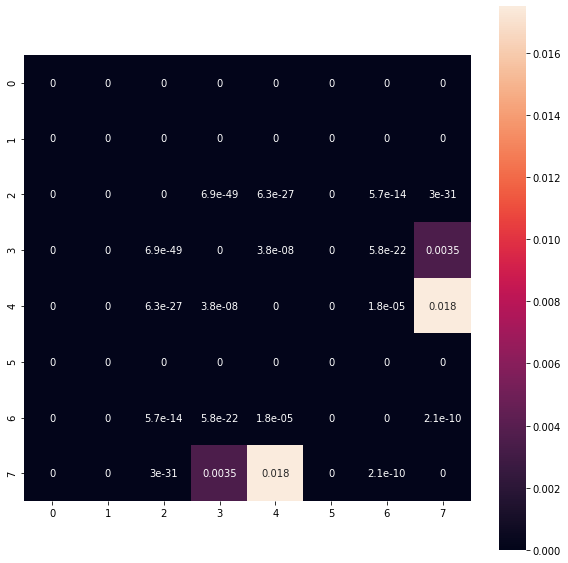

In [54]:
plt.figure(figsize=(10,10))
sns.heatmap(testRes, annot = True, square=True)

In [55]:
dfAirScaledMedian2020

,id_amat,valore,normv
0,2,12.0,0.153846
1,3,2.1,0.281250
2,4,11.0,0.250000
3,6,15.0,0.218750
4,7,51.0,0.255556


Retrieving data from geojson for stations.

In [60]:
import json
from urllib.request import urlopen
#Source: https://dati.comune.milano.it/dataset/ds484_stazioni_di_monitoraggio_inquinanti_atmosferici_dellarpa_sit/resource/635c6508-b335-48b1-b3c8-d43e78ad3380
stationsPath = 'https://dati.comune.milano.it/dataset/d6960c75-0a02-4fda-a85f-3b1c4aa725d6/resource/635c6508-b335-48b1-b3c8-d43e78ad3380/download/qaria_stazione.geojson'

# with open(stationsPath) as data_file:
#     data = json.load(data_file)
data = urlopen(stationsPath)
data = json.load(data)
dctStations = {"id_amat":[], 
               "name" : [], 
               "coords" : []}

for i in data["features"]:
    dctStations["id_amat"].append(i["properties"]["id_amat"])
    dctStations["name"].append(i["properties"]["nome"])
    dctStations["coords"].append([i["geometry"]["coordinates"][1], i["geometry"]["coordinates"][0]])
    
dfStations = pd.DataFrame(dctStations)
dfStations

,id_amat,name,coords
0,1,p.le Abbiategrasso,"[45.432300567627, 9.18218994140625]"
1,3,viale Liguria,"[45.4441986083984, 9.16944026947021]"
2,4,viale Marche,"[45.4962997436523, 9.19083976745605]"
3,5,Parco Lambro,"[45.4995994567871, 9.24730014801025]"
4,7,Verziere,"[45.4635009765625, 9.19534015655518]"
5,8,p.le Zavattari,"[45.4761009216309, 9.141770362854]"
6,9,via Juvara,"[45.4734992980957, 9.22045040130615]"
7,2,via Pascal *,"[45.4740982055664, 9.23478031158447]"
8,6,via Senato *,"[45.4705009460449, 9.19791984558105]"


In [61]:
dfStations.to_pickle("dfStations.pkl")

In [46]:
dfAirScaledMedianStations = dfAirScaledMedian.merge(dfStations, left_on='id_amat', right_on='id_amat')
dfAirScaledMedianStations

,id_amat,valore,normv,name,coords
0,2,12.0,0.153846,via Pascal *,"[45.4740982055664, 9.23478031158447]"
1,3,2.2,0.281250,viale Liguria,"[45.4441986083984, 9.16944026947021]"
2,4,10.0,0.240000,viale Marche,"[45.4962997436523, 9.19083976745605]"
3,6,14.0,0.214953,via Senato *,"[45.4705009460449, 9.19791984558105]"
4,7,52.0,0.261397,Verziere,"[45.4635009765625, 9.19534015655518]"


Need to separate the coordinates for further modelling

In [47]:
dfAirScaledMedianStations["lt"] = dfAirScaledMedianStations["coords"].map(lambda x: x[0])
dfAirScaledMedianStations["lg"] = dfAirScaledMedianStations["coords"].map(lambda x: x[1])
dfAirScaledMedianStations

,id_amat,valore,normv,name,coords,lt,lg
0,2,12.0,0.153846,via Pascal *,"[45.4740982055664, 9.23478031158447]",45.474098,9.23478
1,3,2.2,0.281250,viale Liguria,"[45.4441986083984, 9.16944026947021]",45.444199,9.16944
2,4,10.0,0.240000,viale Marche,"[45.4962997436523, 9.19083976745605]",45.496300,9.19084
3,6,14.0,0.214953,via Senato *,"[45.4705009460449, 9.19791984558105]",45.470501,9.19792
4,7,52.0,0.261397,Verziere,"[45.4635009765625, 9.19534015655518]",45.463501,9.19534


In [48]:
dfAirScaledMedianStations.to_csv("5_dfAirScaledMedianStations.csv", index = False)

### 6. Creating model for predicting air quality score based on location

In [ ]:

#data = dfAirScaledMedianStations
def generateContaminationModel(data):
    pf = PolynomialFeatures(degree=3)
    X = pf.fit_transform(data[["lt","lg"]])

    y = data[["normv"]]
    lr = LinearRegression()
    lr.fit(X,y)
    return lr

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=3)
X = pf.fit_transform(dfAirScaledMedianStations[["lt","lg"]])

y = dfAirScaledMedianStations[["normv"]]
lr = LinearRegression()
lr.fit(X,y)

print(lr.coef_)
print(lr.intercept_)

[[-8.45483422e-04 -4.91689189e+00  1.07321934e+01 -2.24737443e+02
   2.21190418e+02  9.85371913e+01  3.58566966e+00 -4.05695406e+00
  -5.26270217e+00  3.58677095e+00]]
[121444.598028]


In [50]:
def predictContamination(lt, lg):
    """
    The function returns contamination values based on location
    Input:
    lt (float): latitude
    lg (float): longitude
    
    Output:
    Scaled contamaination value
    """
    return lr.predict(pf.fit_transform([np.array([lt,lg])]))[0][0]

In [51]:
#checking
predictContamination(45.474098, 9.23478)

0.15384977529174648

Saving the model for further map creation.

In [52]:
import pickle

pkl_filename = "lr.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lr, file)


### 7. Data on available apartments for rent

Getting data on existing offers for rent in Milan

In [ ]:
def predictContamination(lt, lg, pf=):
    """
    The function returns contamination values based on location
    Input:
    lt (float): latitude
    lg (float): longitude
    
    Output:
    Scaled contamaination value
    """
    return lr.predict(pf.fit_transform([np.array([lt,lg])]))[0][0]

def getLoc(address, annot = True):
    """
    The function returns coordinates of address.
    Input:
    address (str): address
    
    Output:
    list(float): [latitude, longitude] or np.nan if not found
    """
    try:
        location = geolocator.geocode(address)
        if annot:
            print(address + " was succesfully added\n")
        return [location[1][0], location[1][1]]
        
    except:
        if annot:
            print(address + " was skipped. Probably was not found\n")
        return np.nan
    
def getObjects(minPrice = 500, maxPrice = 5000, maxPages = 50):
    urlList = [f"https://www.immobiliare.it/affitto-case/milano/?criterio=rilevanza&prezzoMinimo={minPrice}&prezzoMassimo={maxPrice}"]
    urlList+=[f"https://www.immobiliare.it/affitto-case/milano/?criterio=rilevanza&prezzoMinimo={minPrice}&prezzoMassimo={maxPrice}&pag={i+1}" for i in range(maxPages)]

    objects = {"id":[],
               "type":[], 
               "address":[],
               "price":[]}
    for url in urlList:
        session = requests.session()
        response = session.get(url+"&boxAuto[]=1&boxAuto[]=4")

        soup = BeautifulSoup(response.text, 'html.parser')

        for element in soup.find_all('p', class_='titolo text-primary'):
            try:
                name = element.text.strip().split()
                objects["id"].append(element.find('a').get("id"))
                objects["type"].append(name[0])
                objects["address"].append(" ".join(name[1:]))
            except:
                pass

        for element in soup.find_all('li', class_='lif__item lif__pricing'):
            try:
                if element.find('div')==None:

                    price = element.text.strip().split()[1]
                    price= price.replace(".","")
                    objects["price"].append(int(price))
                else:

                    price = element.find('div').text.strip().split()[1]
                    price= price.replace(".","")

                    objects["price"].append(int(price))
            except:
                pass

            #Sanity check        
    assert len(objects["id"]) == len(objects["type"]) == len(objects["address"]) == len(objects["price"])
    print(f"All successful. {len(objects['id'])} objects has been added")
    
    dfObjects = pd.DataFrame(objects)
    dfObjects["coords"] = dfObjects["address"].map(getLoc)
    dfObjects.dropna(inplace = True)
    dfObjects["contamination"] = dfObjects["coords"].map(lambda x: predictContamination(x[0], x[1]))
    

In [53]:
minPrice = 500
maxPrice = 5000
maxPages = 50
urlList = [f"https://www.immobiliare.it/affitto-case/milano/?criterio=rilevanza&prezzoMinimo={minPrice}&prezzoMassimo={maxPrice}"]
urlList+=[f"https://www.immobiliare.it/affitto-case/milano/?criterio=rilevanza&prezzoMinimo={minPrice}&prezzoMassimo={maxPrice}&pag={i+1}" for i in range(maxPages)]

objects = {"id":[],
           "type":[], 
           "address":[],
           "price":[]}
for url in urlList:
    session = requests.session()
    response = session.get(url+"&boxAuto[]=1&boxAuto[]=4")

    soup = BeautifulSoup(response.text, 'html.parser')

    for element in soup.find_all('p', class_='titolo text-primary'):
        try:
            name = element.text.strip().split()
            objects["id"].append(element.find('a').get("id"))
            objects["type"].append(name[0])
            objects["address"].append(" ".join(name[1:]))
        except:
            pass

    for element in soup.find_all('li', class_='lif__item lif__pricing'):
        try:
            if element.find('div')==None:

                price = element.text.strip().split()[1]
                price= price.replace(".","")
                objects["price"].append(int(price))
            else:
                
                price = element.find('div').text.strip().split()[1]
                price= price.replace(".","")
            
                objects["price"].append(int(price))
        except:
            pass

        #Sanity check        
assert len(objects["id"]) == len(objects["type"]) == len(objects["address"]) == len(objects["price"])
print(f"All successful. {len(objects['id'])} objects has been added")

All successful. 1056 objects has been added


In [54]:
dfObjects = pd.DataFrame(objects)
dfObjects

,id,type,address,price
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000
2,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200
3,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550
4,link_ad_83000949,Bilocale,"via Carlo Imbonati 64, Dergano, Milano",1300
...,...,...,...,...
1051,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750
1052,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100
1053,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850
1054,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600


In [55]:
def getLoc(address, annot = True):
    """
    The function returns coordinates of address.
    Input:
    address (str): address
    
    Output:
    list(float): [latitude, longitude] or np.nan if not found
    """
    try:
        location = geolocator.geocode(address)
        if annot:
            print(address + " was succesfully added\n")
        return [location[1][0], location[1][1]]
        
    except:
        if annot:
            print(address + " was skipped. Probably was not found\n")
        return np.nan


In [56]:
dfObjects["coords"] = dfObjects["address"].map(getLoc)

piazzale Biancamano 2, Moscova, Milano was succesfully added

corso Magenta, San Vittore, Milano was succesfully added

via Archimede, Plebisciti - Susa, Milano was succesfully added

via Sansovino 3, Città Studi, Milano was succesfully added

via Carlo Imbonati 64, Dergano, Milano was succesfully added

corso Giuseppe Garibaldi 95, Moscova, Milano was succesfully added

viale Coni Zugna, Dezza, Milano was succesfully added

corso Giuseppe Garibaldi 95, Moscova, Milano was succesfully added

corso Giuseppe Garibaldi 95, Moscova, Milano was succesfully added

via Archimede, Indipendenza, Milano was succesfully added

ottimo stato, 11, Duomo, Milano was succesfully added

ottimo stato, nono piano, Duomo, Milano was succesfully added

viale Legioni Romane 8, Bande Nere, Milano was succesfully added

corso Magenta, San Vittore, Milano was succesfully added

via Pinamonte da Vimercate, Moscova, Milano was succesfully added

via Fratelli Gabba, Brera, Milano was succesfully added

via Giorgi

nuovo, quarto piano, Porta Nuova, Milano was succesfully added

via Carlo Imbonati 62, Dergano, Milano was succesfully added

via Giovanni Battista Pirelli 30, Melchiorre Gioia, Milano was succesfully added

via Andrea Maria Ampère 56, Città Studi, Milano was succesfully added

via Carlo Dolci 32, San Siro, Milano was succesfully added

via Labeone 6, Argonne - Corsica, Milano was succesfully added

via Galla Placidia 9, Città Studi, Milano was succesfully added

via Lattanzio, Lodi - Brenta, Milano was succesfully added

ottimo stato, secondo piano, Cadorna - Castello, Milano was succesfully added

ottimo stato, secondo piano, Cadorna - Castello, Milano was skipped. Probably was not found

via degli Arcimboldi 5, Missori, Milano was succesfully added

Vincenzo Monti 54, Vincenzo Monti, Milano was succesfully added

via Giambellino, Giambellino, Milano was succesfully added

via Mario Pagano 49, Pagano, Milano was succesfully added

via Nino Bixio 15, Piave - Tricolore, Milano was succ

via San Gerolamo Emiliani 10, Porta Romana - Medaglie d'Oro, Milano was succesfully added

via dei Fontanili 32, Ripamonti, Milano was succesfully added

via De Togni, San Vittore, Milano was succesfully added

via Bastia 4, Ripamonti, Milano was succesfully added

via Privata della Passarella 4, Duomo, Milano was succesfully added

via Correggio 41, De Angeli, Milano was succesfully added

via Volturno, Isola, Milano was succesfully added

via Giorgio Washington 59, Washington, Milano was succesfully added

via Cappuccini, Palestro, Milano was succesfully added

via Carlo Maria Maggi 2, Arena, Milano was succesfully added

piazza Santo Stefano 5, Borgogna - Largo Augusto, Milano was succesfully added

via Caradosso, Vincenzo Monti, Milano was succesfully added

a schiera piazza Niccolò Tommaseo 2, Vincenzo Monti, Milano was succesfully added

via Vergani Marelli 1, Bande Nere, Milano was succesfully added

viale Sarca 326, Bignami - Ponale, Milano was succesfully added

via Morigi, Ca

via Lazzaro Papi, Porta Romana - Medaglie d'Oro, Milano was succesfully added

via Cerva 12, Borgogna - Largo Augusto, Milano was succesfully added

via castellanza 7, Gallaratese, Milano was succesfully added

via Gaetano Donizetti, Palestro, Milano was succesfully added

via Giovanni Spadolini, Ripamonti, Milano was succesfully added

via Val Morea 6, Baggio, Milano was succesfully added

largo Cairoli, Cadorna - Castello, Milano was succesfully added

alzaia Naviglio Pavese 260, Cantalupa - San Paolo, Milano was succesfully added

via Giuseppe Ugolini 27, Greco - Segnano, Milano was succesfully added

via Michelangelo Buonarroti, Vercelli - Wagner, Milano was succesfully added

via Giuseppe Ripamonti 1, Porta Romana - Medaglie d'Oro, Milano was succesfully added

viale Bligny 25, Bocconi, Milano was succesfully added

via Sant'Ampellio 5, Pezzotti - Meda, Milano was succesfully added

largo La Foppa 2, Moscova, Milano was succesfully added

via Giuseppe Govone 100, Ghisolfa - Mac Ma

via Palmanova 67, Cimiano, Milano was succesfully added

via Antonio Tantardini, Corso San Gottardo, Milano was succesfully added

via Nicostrato Castellini, Farini, Milano was succesfully added

via Livigno 2, Dergano, Milano was succesfully added

via Marco Polo, Porta Nuova, Milano was succesfully added

via Lazzaro Papi, Porta Romana - Medaglie d'Oro, Milano was succesfully added

via Padova 149, Cimiano, Milano was succesfully added

via Giovanni Battista Niccolini 37, Paolo Sarpi, Milano was succesfully added

via Carlo Torre 39, Navigli - Darsena, Milano was succesfully added

via Vigevano, Navigli - Darsena, Milano was succesfully added

via Losanna, Sempione, Milano was succesfully added

via Gabbro 8, Affori, Milano was succesfully added

via Quadrio 9, Garibaldi - Corso Como, Milano was succesfully added

via Lazzaro Papi, Porta Romana - Medaglie d'Oro, Milano was succesfully added

via conca del naviglio 37, Ticinese, Milano was succesfully added

via Antonio Tolomeo Trivul

piazza della Trivulziana 6, Bicocca, Milano was succesfully added

via Lazzaro Papi, Porta Romana - Medaglie d'Oro, Milano was succesfully added

via EMILIO BROGLIO, Bovisa, Milano was succesfully added

via Carlo Crivelli, Quadronno - Crocetta, Milano was succesfully added

viale Monza 24, Pasteur, Milano was succesfully added

viale Cassala 3, Navigli - Darsena, Milano was succesfully added

via Lazzaro Papi, Porta Romana - Medaglie d'Oro, Milano was succesfully added

via Giovanni Battista Pirelli 35, Melchiorre Gioia, Milano was succesfully added

via Lazzaro Papi 20, Porta Romana - Medaglie d'Oro, Milano was succesfully added

via Tucidide 56, Ortica, Milano was succesfully added

via Filippo Argelati 47A, Navigli - Darsena, Milano was succesfully added

via Coluccio Salutati 2A, Vercelli - Wagner, Milano was succesfully added

via Carlo Bellerio 40, Affori, Milano was succesfully added

piazza Riccardo Wagner 5, Vercelli - Wagner, Milano was succesfully added

unifamiliare viale 

via Gerolamo Avogadro, Tre Castelli - Faenza, Milano was succesfully added

via Piero Caldirola, Bicocca, Milano was succesfully added

viale della Liberazione 15, Porta Nuova, Milano was succesfully added

via Cerva 11, Borgogna - Largo Augusto, Milano was succesfully added

corso Giuseppe Garibaldi 73, Lanza, Milano was succesfully added

Ripa di Porta Ticinese 127B, Navigli - Darsena, Milano was succesfully added

via Varesina, Certosa, Milano was succesfully added

via dei Fontanili, Ripamonti, Milano was succesfully added

via dei Fontanili, Ripamonti, Milano was succesfully added

via Palmanova 185, Crescenzago, Milano was succesfully added

ottimo stato, secondo piano, Giambellino, Milano was succesfully added

ottimo stato, secondo piano, Giambellino, Milano was succesfully added

via Cantello, Baggio, Milano was succesfully added

via Moncucco 22, Famagosta, Milano was succesfully added

via Spadolini, Ripamonti, Milano was succesfully added

via Andrea Verga, Vercelli - Wagne

via Archimede 73, Indipendenza, Milano was succesfully added

ottimo stato, primo piano, Brera, Milano was succesfully added

via Ponte Seveso, Centrale, Milano was succesfully added

via Livigno 4-3, Dergano, Milano was succesfully added

via Lazzaro Papi 20, Porta Romana - Medaglie d'Oro, Milano was succesfully added

via Olgiati, Tre Castelli - Faenza, Milano was succesfully added

via Nerino, Carrobbio, Milano was succesfully added

viale Puglie, Bologna - Sulmona, Milano was succesfully added

via AROSIO, San Siro, Milano was succesfully added

via Del Fusaro, Washington, Milano was succesfully added

viale Bligny 52, Bocconi, Milano was succesfully added

buono stato, quinto piano, Quadronno - Crocetta, Milano was succesfully added

via Mario Pannunzio 4, Certosa, Milano was succesfully added

corso Como 12, Garibaldi - Corso Como, Milano was succesfully added

via Adamello, Ripamonti, Milano was succesfully added

piazza DELLA TRIVULZIANA, 5, Milano was succesfully added

via La

via Cascina Bianca, Cantalupa - San Paolo, Milano was succesfully added

viale Affori, Affori, Milano was succesfully added

via Felice Perussia 12, Chiesa Rossa, Milano was succesfully added

via Palmanova 219, Crescenzago, Milano was succesfully added

via Scaldasole 4, Ticinese, Milano was succesfully added

via Sangro 8, Udine, Milano was succesfully added

via Enrico Cosenz 54, Bovisa, Milano was succesfully added

via degli Umiliati 21, Ponte Lambro, Milano was succesfully added

via Tucidide 56, Ortica, Milano was succesfully added

via Parenzo 8, Tre Castelli - Faenza, Milano was succesfully added

via Chianciano 10-2, Affori, Milano was succesfully added

via Paul Valery 3, Famagosta, Milano was succesfully added

via del Futurismo 6, Santa Giulia, Milano was succesfully added

via Filippo Tommaso Marinetti 3, Turro, Milano was succesfully added

via Monte Velino 7, Molise - Cuoco, Milano was succesfully added

via Monte Velino 7, Molise - Cuoco, Milano was skipped. Probably w

In [57]:
dfObjects.dropna(inplace = True)
dfObjects

,id,type,address,price,coords
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000,"[45.47823899999999, 9.1819484]"
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000,"[45.4657096, 9.1717594]"
2,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200,"[45.4681442, 9.2225773]"
3,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550,"[45.4793396, 9.217790599999999]"
4,link_ad_83000949,Bilocale,"via Carlo Imbonati 64, Dergano, Milano",1300,"[45.50395839999999, 9.182326399999999]"
...,...,...,...,...,...
1051,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750,"[45.4737135, 9.2091615]"
1052,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100,"[45.493978, 9.1467958]"
1053,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850,"[45.5088178, 9.1395781]"
1054,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600,"[45.4823633, 9.1833156]"


Predicting contamination for existing objects

In [58]:
dfObjects["contamination"] = dfObjects["coords"].map(lambda x: predictContamination(x[0], x[1]))

In [59]:
dfObjects

,id,type,address,price,coords,contamination
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000,"[45.47823899999999, 9.1819484]",0.179727
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000,"[45.4657096, 9.1717594]",0.156972
2,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200,"[45.4681442, 9.2225773]",0.251286
3,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550,"[45.4793396, 9.217790599999999]",0.144029
4,link_ad_83000949,Bilocale,"via Carlo Imbonati 64, Dergano, Milano",1300,"[45.50395839999999, 9.182326399999999]",0.359669
...,...,...,...,...,...,...
1051,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750,"[45.4737135, 9.2091615]",0.197721
1052,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100,"[45.493978, 9.1467958]",0.312934
1053,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850,"[45.5088178, 9.1395781]",0.640025
1054,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600,"[45.4823633, 9.1833156]",0.188212


### Calculate distance to the nearest dangerous zone

In [60]:
from math import radians, cos, sin, asin, sqrt
def dist(loc1, loc2):
    """
    Function returns the distance between two locations
    
    Input:
    loc1 (list(float)): location 1: [latitude, longitude]
    loc2 (list(float)): location 2: [latitude, longitude]
    
    Output:
    km: distance in km
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [loc1[1], loc1[0], loc2[1], loc2[0]])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

#### Dangerous zones coordinates

In [61]:
blackList = ["Quarto Oggiaro", "Roserio", "viale Padova", "Bovisa", "Rogored", "Barona", "Corvetto", "San Siro", "Via Gola"]
dangerousZones = [getLoc(i) for i in blackList]
dangerousZones

Quarto Oggiaro was succesfully added

Roserio was succesfully added

viale Padova was succesfully added

Bovisa was succesfully added

Rogored was succesfully added

Barona was succesfully added

Corvetto was succesfully added

San Siro was succesfully added

Via Gola was succesfully added



[[45.51072300000001, 9.137585399999999],
 [45.51908539999999, 9.124203399999999],
 [45.5026549, 9.238589],
 [45.5065037, 9.1597554],
 [45.431403, 9.243685],
 [32.9390049, -116.8736109],
 [45.4401682, 9.2242604],
 [45.4781236, 9.123961999999999],
 [45.4495399, 9.1752465]]

In [62]:
dfObjects["distanceToDangerZone"]=dfObjects["coords"].map(lambda x: min([dist(x, i) for i in dangerousZones]))
dfObjects

,id,type,address,price,coords,contamination,distanceToDangerZone
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000,"[45.47823899999999, 9.1819484]",0.179727,3.233713
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000,"[45.4657096, 9.1717594]",0.156972,1.818443
2,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200,"[45.4681442, 9.2225773]",0.251286,3.113558
3,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550,"[45.4793396, 9.217790599999999]",0.144029,3.057725
4,link_ad_83000949,Bilocale,"via Carlo Imbonati 64, Dergano, Milano",1300,"[45.50395839999999, 9.182326399999999]",0.359669,1.781589
...,...,...,...,...,...,...,...
1051,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750,"[45.4737135, 9.2091615]",0.197721,3.771147
1052,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100,"[45.493978, 9.1467958]",0.312934,1.720479
1053,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850,"[45.5088178, 9.1395781]",0.640025,0.262662
1054,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600,"[45.4823633, 9.1833156]",0.188212,3.252353


### Calculating distances to median job location

In [63]:
dfObjects["distanceToMedianJobLocation"]=dfObjects["coords"].map(lambda x: dist(x, medianLocation))
dfObjects

,id,type,address,price,coords,contamination,distanceToDangerZone,distanceToMedianJobLocation
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000,"[45.47823899999999, 9.1819484]",0.179727,3.233713,1.518806
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000,"[45.4657096, 9.1717594]",0.156972,1.818443,1.399301
2,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200,"[45.4681442, 9.2225773]",0.251286,3.113558,2.577938
3,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550,"[45.4793396, 9.217790599999999]",0.144029,3.057725,2.663466
4,link_ad_83000949,Bilocale,"via Carlo Imbonati 64, Dergano, Milano",1300,"[45.50395839999999, 9.182326399999999]",0.359669,1.781589,4.291826
...,...,...,...,...,...,...,...,...
1051,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750,"[45.4737135, 9.2091615]",0.197721,3.771147,1.759168
1052,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100,"[45.493978, 9.1467958]",0.312934,1.720479,4.590358
1053,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850,"[45.5088178, 9.1395781]",0.640025,0.262662,6.184304
1054,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600,"[45.4823633, 9.1833156]",0.188212,3.252353,1.917659


### Defining Zone for each object

In [64]:
import json
from shapely.geometry import shape, Point
with open('zonedecentramento.geojson') as f:
    js = json.load(f)
# load GeoJSON file containing sectors
def getZone(loc, js):

    #
    point = Point(min(loc), max(loc))

    # check each polygon to see if it contains the point
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature["properties"]['ZONADEC']

In [65]:
dfObjects["Zone"] = dfObjects["coords"].map(lambda x: getZone(x, js))

### Defining Vegetation Concentration for each object based on the zone

In [66]:
dfObjects

,id,type,address,price,coords,contamination,distanceToDangerZone,distanceToMedianJobLocation,Zone
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000,"[45.47823899999999, 9.1819484]",0.179727,3.233713,1.518806,1.0
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000,"[45.4657096, 9.1717594]",0.156972,1.818443,1.399301,1.0
2,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200,"[45.4681442, 9.2225773]",0.251286,3.113558,2.577938,3.0
3,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550,"[45.4793396, 9.217790599999999]",0.144029,3.057725,2.663466,3.0
4,link_ad_83000949,Bilocale,"via Carlo Imbonati 64, Dergano, Milano",1300,"[45.50395839999999, 9.182326399999999]",0.359669,1.781589,4.291826,9.0
...,...,...,...,...,...,...,...,...,...
1051,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750,"[45.4737135, 9.2091615]",0.197721,3.771147,1.759168,3.0
1052,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100,"[45.493978, 9.1467958]",0.312934,1.720479,4.590358,8.0
1053,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850,"[45.5088178, 9.1395781]",0.640025,0.262662,6.184304,8.0
1054,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600,"[45.4823633, 9.1833156]",0.188212,3.252353,1.917659,9.0


In [67]:
dfGreen

,ZONADEC,GreenArea,TotalArea,GreenConc
0,1,1.108470,9.67,0.114630
1,2,1.067198,12.58,0.084833
2,3,1.732050,14.23,0.121718
3,4,2.133899,20.95,0.101857
4,5,1.745979,29.87,0.058453
5,6,2.125662,18.28,0.116283
6,7,5.294581,31.34,0.168940
7,8,3.549903,23.72,0.149659
8,9,3.677692,21.12,0.174133


In [68]:
dfObjects= pd.merge(dfObjects, dfGreen, left_on='Zone', right_on="ZONADEC", right_index=False, how='left', sort=False) 

In [69]:
dfObjects

,id,type,address,price,coords,contamination,distanceToDangerZone,distanceToMedianJobLocation,Zone,ZONADEC,GreenArea,TotalArea,GreenConc
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000,"[45.47823899999999, 9.1819484]",0.179727,3.233713,1.518806,1.0,1.0,1.108470,9.67,0.114630
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000,"[45.4657096, 9.1717594]",0.156972,1.818443,1.399301,1.0,1.0,1.108470,9.67,0.114630
2,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200,"[45.4681442, 9.2225773]",0.251286,3.113558,2.577938,3.0,3.0,1.732050,14.23,0.121718
3,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550,"[45.4793396, 9.217790599999999]",0.144029,3.057725,2.663466,3.0,3.0,1.732050,14.23,0.121718
4,link_ad_83000949,Bilocale,"via Carlo Imbonati 64, Dergano, Milano",1300,"[45.50395839999999, 9.182326399999999]",0.359669,1.781589,4.291826,9.0,9.0,3.677692,21.12,0.174133
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750,"[45.4737135, 9.2091615]",0.197721,3.771147,1.759168,3.0,3.0,1.732050,14.23,0.121718
1044,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100,"[45.493978, 9.1467958]",0.312934,1.720479,4.590358,8.0,8.0,3.549903,23.72,0.149659
1045,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850,"[45.5088178, 9.1395781]",0.640025,0.262662,6.184304,8.0,8.0,3.549903,23.72,0.149659
1046,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600,"[45.4823633, 9.1833156]",0.188212,3.252353,1.917659,9.0,9.0,3.677692,21.12,0.174133


In [70]:
dfObjects.drop(columns=["TotalArea","GreenArea", "ZONADEC"], inplace = True)


In [71]:
 dfObjects.columns = list(dfObjects.columns[:-1])+["GreenConc"]

In [75]:
dfObjects["lt"] = dfObjects["coords"].map(lambda x: x[0])
dfObjects["lg"] = dfObjects["coords"].map(lambda x: x[1])

In [76]:
dfObjects

,id,type,address,price,coords,contamination,distanceToDangerZone,distanceToMedianJobLocation,Zone,GreenConc,lt,lg
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000,"[45.47823899999999, 9.1819484]",0.179727,3.233713,1.518806,1.0,0.114630,45.478239,9.181948
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000,"[45.4657096, 9.1717594]",0.156972,1.818443,1.399301,1.0,0.114630,45.465710,9.171759
2,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200,"[45.4681442, 9.2225773]",0.251286,3.113558,2.577938,3.0,0.121718,45.468144,9.222577
3,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550,"[45.4793396, 9.217790599999999]",0.144029,3.057725,2.663466,3.0,0.121718,45.479340,9.217791
4,link_ad_83000949,Bilocale,"via Carlo Imbonati 64, Dergano, Milano",1300,"[45.50395839999999, 9.182326399999999]",0.359669,1.781589,4.291826,9.0,0.174133,45.503958,9.182326
...,...,...,...,...,...,...,...,...,...,...,...,...
1043,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750,"[45.4737135, 9.2091615]",0.197721,3.771147,1.759168,3.0,0.121718,45.473714,9.209162
1044,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100,"[45.493978, 9.1467958]",0.312934,1.720479,4.590358,8.0,0.149659,45.493978,9.146796
1045,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850,"[45.5088178, 9.1395781]",0.640025,0.262662,6.184304,8.0,0.149659,45.508818,9.139578
1046,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600,"[45.4823633, 9.1833156]",0.188212,3.252353,1.917659,9.0,0.174133,45.482363,9.183316


In [77]:
dfObjects.to_csv("dfObjectsUnscored.csv", index = False)

### Calculating total scores for each object

In [ ]:
airWeight, safetyWeight, jobWeight, greenWeight, priceWeight  = 5, 5, 5, 5, 5

def totalScore(x, air = airWeight, safety = safetyWeight, 
               job = jobWeight, green = greenWeight, price = priceWeight):
    """
    The function calculates a score based on weights reflecting significance of one or another factor
    Input:
    x (list(float)): a list containg feature values. The sequence is: 
    ["price", "contamination", "distanceToDangerZone", "distanceToMedianJobLocation","GreenConc"]
    
    Output:
    
    """
    #"price", "contamination", "distanceToDangerZone", "distanceToMedianJobLocation","GreenConc"
    return -x[1]*air + x[2]*safety - x[3]*job + x[4]*green - x[0]*price


In [ ]:
dfObjects[["price"]].hist()

Let's scale it and transfor using log function. 

In [ ]:

scaler = preprocessing.MinMaxScaler()
dfObjects["priceLogScaled"] = scaler.fit_transform(np.log(dfObjects[["price"]]))
numColumns = ["priceLogScaled", "contamination", "distanceToDangerZone", 
                     "distanceToMedianJobLocation","GreenConc"]
dfObjects["totalScore"]=dfObjects.apply(lambda x: totalScore([x[i] for i in numColumns]), axis=1)
dfObjects

In [ ]:
dfObjects["priceLogScaled"].hist()

### Saving DF

In [ ]:
dfObjects.to_csv("dfObjects.csv", index = False)

### Creating a model for predicting price

#### Leaving only numerical columns

In [ ]:
numColumns = ["price", "contamination", "distanceToDangerZone", 
                     "distanceToMedianJobLocation","GreenConc"]
dfFinal = dfObjects[["price", "contamination", "distanceToDangerZone", 
                     "distanceToMedianJobLocation","GreenConc"]]
dfFinal

#### Scaling

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaled = scaler.fit_transform(dfFinal)
dfFinal = pd.DataFrame(scaled)
dfFinal.columns = numColumns

In [ ]:
priceWeight = 5
dfFinal["totalScore"]=dfFinal.apply(lambda x: totalScore([x[i] for i in dfFinal.columns]), axis=1)
dfFinal

In [ ]:
dfObjectsScored = pd.concat([dfObjects[["id", "type", "address", "price","coords","lt","lg"]], dfFinal[["totalScore"]]], axis = 1)

In [ ]:
dfObjectsScored

In [ ]:
dfObjectsScored.to_csv("dfObjectsScored.csv", index = False)

## Some updated to web scraping due to source web site changes
I decided to use Selenium in final version (in dataGeneration.py) as it is more prone to bot blocking issues. 

In [ ]:
import re

from selenium import webdriver
driver = webdriver.Firefox()

companyInfo = {"companyName":[],
               "jobName":[],
               "link":[],
               "lt" : [],
               "lg" : [],
               "address" : []}
for url in urlList:
    driver.get(url)
    html = driver.page_source
    soup = BeautifulSoup(html,'html.parser')

   
    for element in soup.find_all('a', id=re.compile('^job_')):
    #     print(element)

        print(element['href'])
        jobName = element.find('span', class_=lambda x: x != 'label').text
        print(jobName)
        companyInfo["link"].append("https://it.indeed.com"+str(element['href']))
        companyInfo["jobName"].append(jobName)
        name = element.find('span', class_='companyName').text
        print(name)
        companyInfo["companyName"].append(name)
        print('='*10)